In [202]:
import os
import sys

import importlib
import dicom_utils
importlib.reload(dicom_utils)
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio

In [203]:
file_dir = os.path.join(os.getcwd(), "assets", "niftynet_raw_images")
print("Your files are/should be in ", file_dir)
patients = [int(x) for x in os.listdir(file_dir) if len(os.listdir(os.path.join(file_dir, str(x)))) > 0]
patients.sort()
print("\n\nYour available patient IDs are ", patients)

Your files are/should be in  /Users/eiofinova/niftynet/assets/niftynet_raw_images


Your available patient IDs are  [2, 3, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 64, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

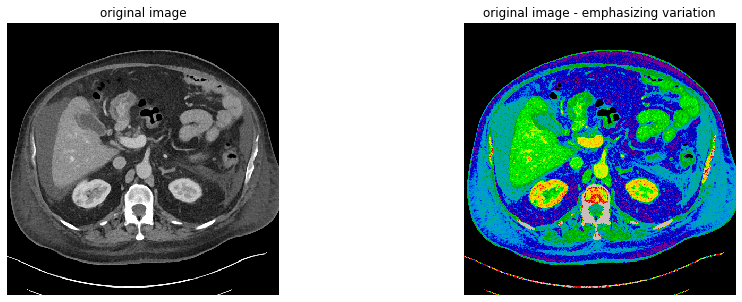

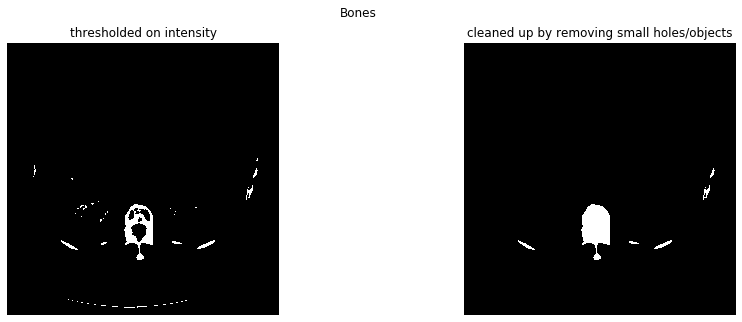

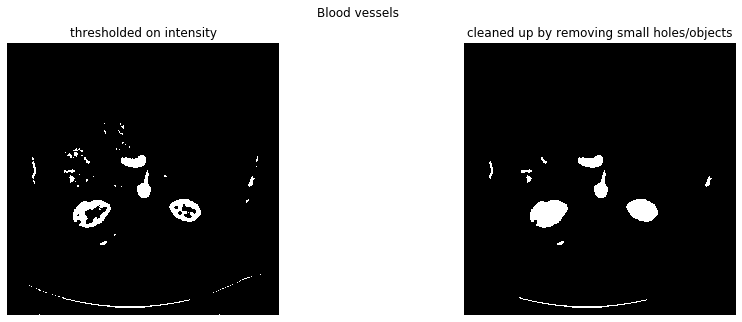

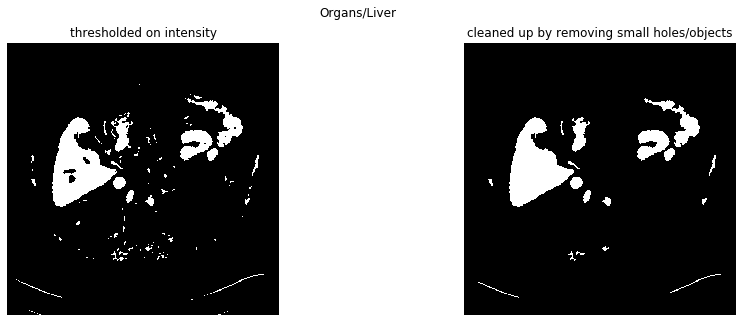

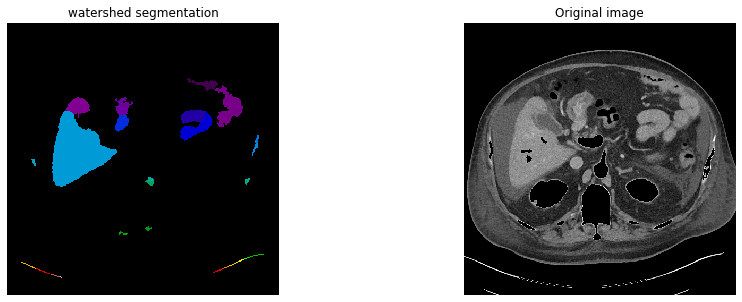

In [204]:
# Set these parameters
patient = 2
slice_idx = 150

# Optionally, also set these.
bones_thresh = [200, 2, 64]
blood_vessels_thresh = [160, 5, 64]
liver_thresh = [125, 1, 64]

# Probably better not to mess with anything below this.
img_path = "assets/niftynet_raw_images/%d/%d.png" % (patient, slice_idx)
img = skio.imread(img_path)

dicom_utils.show_scan(img)
mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones")
img = img * (1 - mask)
mask = dicom_utils.partition_at_threshold(img, *blood_vessels_thresh, title="Blood vessels")
img = img * (1 - mask)
liver = dicom_utils.partition_at_threshold(img, *liver_thresh, title = "Organs/Liver")
dicom_utils.label_image(liver, orig=img)